In [83]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import os

from stable_baselines import DQN
from stable_baselines.common.policies import MlpPolicy
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines import PPO2, A2C, SAC, TD3
from stable_baselines import results_plotter
from stable_baselines.results_plotter import load_results, ts2xy
from stable_baselines.bench import Monitor

import gym

import tensorflow as tf
print("tensorflow:", tf.__version__)

tensorflow: 1.14.0


In [84]:
df = pd.DataFrame( [[random.randint(1, 3) for _ in range(2)] for _ in range(100)] , columns=["a","b"])
df.head(5)

,a,b
0,1,1
1,1,2
2,1,2
3,2,3
4,1,3


In [85]:
sc = StandardScaler()
df_std = pd.DataFrame( sc.fit_transform(df), columns=df.columns)
df_std.head(5)

,a,b
0,-1.219482,-0.956183
1,-1.219482,0.239046
2,-1.219482,0.239046
3,-0.023911,1.434274
4,-1.219482,1.434274


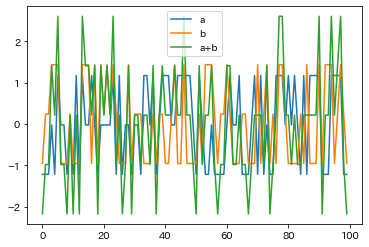

In [86]:
plt.plot(df_std.a, label="a")
plt.plot(df_std.b, label="b")
plt.plot(df_std.a+df_std.b, label="a+b")
plt.legend()
plt.show()

In [87]:
max_val = np.max([np.abs(df_std.max()), np.abs(df_std.min())])

In [88]:
df_std.shape

(100, 2)

In [95]:
kekka = []

class ReinforcementLearning(gym.Env):
    def __init__(self, df):
        super(ReinforcementLearning, self).__init__()
        self.df = df
        
        #Define Action Space and Observation Space
        self.action_space = gym.spaces.Box(low=-max_val, high=max_val, shape=(2, ))
        self.observation_space = gym.spaces.Box(low=-max_val, high=max_val, shape=(1, df_std.shape[1]))
        
    def reset(self):#When self.done == True or the model starts to run, the environment would be reset
        self.current_step = random.randint(0, len(self.df))
        return self.observe()
    
    def take_action(self, action):
        self.action = action

        self.one_set = self.df.iloc[self.current_step].values
        
        if np.abs((np.sum(self.one_set) - np.sum(self.action)))<=1:
            self.reward = 1
        else:
            self.reward = -1
        
        kekka.append(np.abs((np.sum(self.one_set) - np.sum(self.action))))
        
        return self.reward
    def observe(self):
        if self.current_step >= len(self.df):
            self.current_step = 0
        self.obs = self.df.iloc[self.current_step].values
        return self.obs
    
    def step(self, action):
        self.action = action
        self.reward = self.take_action(self.action)
        self.current_step += 1
        if self.reward >=1:
            self.done = True
        else:
            self.done = False
        self.obs = self.observe()
        
        return self.obs, self.reward, self.done, {}

In [96]:
def callback_func(_locals, _globals):
    global n_steps, best_mean_reward
    if n_steps == 0:
        print("model first saved")
        model.save(log_dir + "model")
    x, y = ts2xy(load_results(log_dir), 'timesteps')
    if len(x) > 0:
        mean_reward = np.mean(y)
        if mean_reward > best_mean_reward:
            best_mean_reward = mean_reward
            print("n_steps:", n_steps, "model updated")
            model.save(log_dir + "model")
    n_steps += 1

In [97]:
log_dir = "./log_dir/"
os.makedirs(log_dir, exist_ok=True)

env = ReinforcementLearning(df_std)
env = Monitor(env, log_dir, allow_early_resets=True)
env = DummyVecEnv([lambda: env])

best_mean_reward, n_steps = -np.inf, 0
model = PPO2(MlpPolicy, env, tensorboard_log="./tensorboard/" ,)
model.learn(total_timesteps=100000, callback=callback_func)

In [104]:
#np.abs((np.sum(self.one_set) - np.sum(self.action))

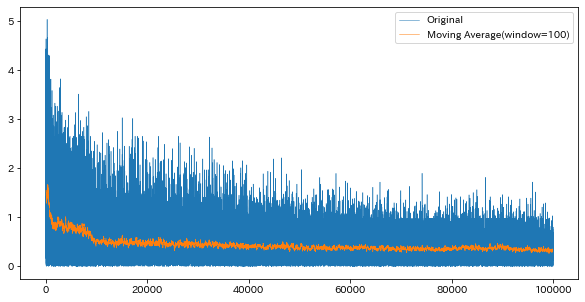

In [117]:
plt.figure(figsize=(10, 5))
plt.plot(kekka, linewidth=.5, label="Original")
plt.plot(pd.Series(kekka).rolling(window=100, center=True).mean(), linewidth=0.5, label="Moving Average(window=100)")
plt.legend()
plt.ylabel=("")

In [ ]:
model1 = PPO2.load(r"log_dir/model.zip")

In [9]:
%load_ext tensorboard
%tensorboard --logdir='./tensorboard'

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 6496), started 0:01:13 ago. (Use '!kill 6496' to kill it.)